# Model

After pre-processing is complete and the data has been stored in a file, load data and train the model.

The format of the data is a np array of shape (total_runs_from_all_subjects, n_channels, n_timestamps)

Which translates to (5184, 22, 1125) for this dataset and these params.

In [35]:
import h5py

def save(filename, inputs, targets):
  file = h5py.File(filename + '.h5', 'w')
  file.create_dataset('inputs', data=inputs)
  file.create_dataset('targets', data=targets)
  file.close()


def load(filename):
  file = h5py.File(filename+'.h5', 'r')
  inputs = file['inputs'][:2304]
  targets = file['targets'][:2304]
  file.close()
  return inputs, targets

In [36]:
inputs, targets = load('all_subject_runs')

In [37]:
print(inputs.shape)

(2304, 22, 1125)


In [38]:
from tensorflow import keras
from tensorflow.keras.constraints import max_norm
import pandas as pd
import pickle
import tensorflow as tf
from keras_uncertainty.layers import DropConnectDense
from keras_uncertainty.utils import numpy_entropy

Maybe convert the epochs to a dataframe
Like:

epcohs_df = windows_dataset.datasets[0].windows.to_data_frame()


Maybe make one of the FC layers use UQ

**SET KERNEL MAXIMUM NORM CONSTRAINT AT 2 AND 0.5 FOR CONVOLUTIONAL AND FC LAYERS RESPECTIVELY**

*Temporal convolution has size of 1 x TimePoints while spatial convolution has size Channels x 1. Spatial convolution is applied after temporal*

In [7]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [39]:
def uncertainty(probs):
  return numpy_entropy(probs, axis=-1)


def create_model():

      weights_filepath = 'TBD'

      C = 22          # Number of electrodes
      T = 1125        # Time samples of network input

      k_1 = 40        # K is number of convolutional kernels. SUBJECT TO HYPERPARAM TUNING
      f_1 = 25        # F is kernel size SUBJECT TO HYPERPARAM TUNING
      s_1 = (1,1)     # Strides size
      p_1 = (0,0)     # Padding size

      k_2 = 40
      f_2 = C
      s_2 = (1,1)
      p_2 = (0,0)

      m = 0.9
      alpha = 1
      f_p = (1, 75)   # Fp is pooling size
      s_p = (1, 15)   # Sp is pool stride

      Nc = 4          # Number of classes

      # FIND OUT RIGHT INPUT SHAPE
      model = keras.models.Sequential([
              # keras.layers.Input(shape=(1, C, T)),
              keras.layers.Conv2D(f_1,  k_1, padding = 'SAME',
                                  activation="linear",
                                  input_shape = (C, T, 1),
                                  kernel_constraint = max_norm(2)),
              keras.layers.Conv2D(f_2,  k_2, padding = 'SAME',
                                  input_shape = (1, C, T),
                                  activation="linear",
                                  kernel_constraint = max_norm(2)),

              keras.layers.BatchNormalization(momentum=0.9, epsilon=0.00001),
              keras.layers.ELU(alpha=1.0),
              keras.layers.AveragePooling2D(pool_size= f_p, strides= s_p),
              keras.layers.ELU(alpha=1.0),

              keras.layers.Flatten(),
              DropConnectDense(Nc, activation='softmax', prob=0.05, kernel_constraint = max_norm(0.5))
          ])

      # model.load_weights(weights_filepath)
      optimizer = keras.optimizers.Adam(learning_rate=1e-4)
      model.compile(loss="categorical_crossentropy",
                    optimizer=optimizer, metrics=["accuracy"])
      return model


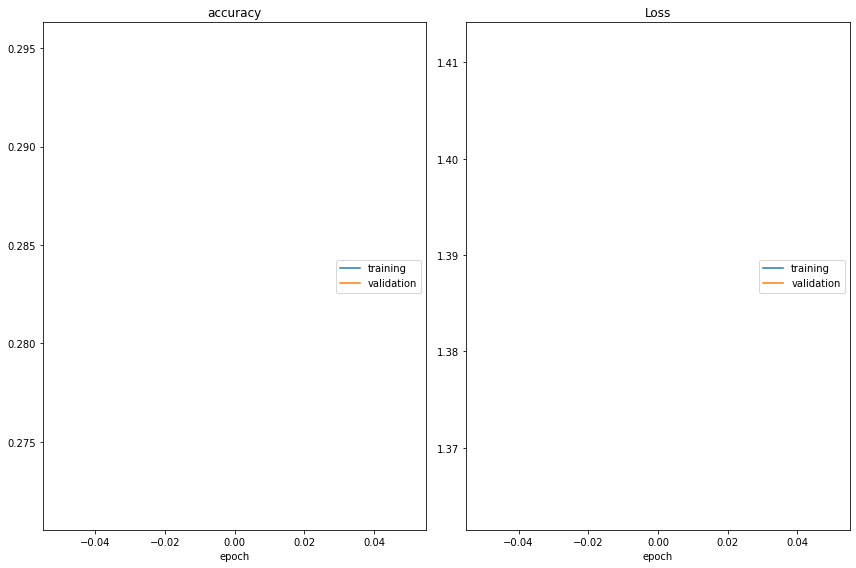

accuracy
	training         	 (min:    0.272, max:    0.272, cur:    0.272)
	validation       	 (min:    0.295, max:    0.295, cur:    0.295)
Loss
	training         	 (min:    1.412, max:    1.412, cur:    1.412)
	validation       	 (min:    1.364, max:    1.364, cur:    1.364)
36/36 [==============================] - 17s 467ms/step - loss: 1.4118 - accuracy: 0.2717 - val_loss: 1.3639 - val_accuracy: 0.2951
entropy shape: (576,)
 entropy: [1.3758206 1.3776772 1.3567504 1.3646176 1.3747704 1.3608408 1.3692398
 1.3647447 1.3763977 1.2923254 1.3771682 1.3648553 1.3788569 1.3757918
 1.346731  1.2808467 1.2315567 1.3448555 1.2451934 1.3830447 1.3422053
 1.3782066 1.3657355 1.3513843 1.3725443 1.2918926 1.3728408 1.3717008
 1.371271  1.3796606 1.3807725 1.3138537 1.3808169 1.3659812 1.3644415
 1.3725094 1.3624319 1.3628858 1.3762751 1.3605803 1.353251  1.3711636
 1.3754762 1.3618959 1.3620079 1.3685145 1.3575728 1.3388642 1.312127
 1.3704958 1.3747039 1.3743532 1.3777728 1.3725164 1.2202114 1

In [54]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
from keras_uncertainty.models import StochasticClassifier
from livelossplot import PlotLossesKeras

# Use 1 subject as Final test set.
# Use remaining 8 subjects as train/val

# Make the subject selection random

n_epochs= 1
num_subjects = 4
num_runs_per_subject = 576 # Dataset-derived parameter

# Train set is first 3 subjects
# This shit is bordering cross-subject data contamination man...]
train_set = dict(inputs= inputs[:(576 * 3)], targets= targets[:(576 * 3)])

# Test set is last subject
test_set = dict(inputs= inputs[(576 * 3):], targets= targets[(576 * 3):])

# kfold split on the 3 training subjects data
kfold = KFold(n_splits=num_subjects - 1, shuffle=False)

fit_params = {"epochs: ", n_epochs}
early_stopping = EarlyStopping(monitor='loss', patience=3)

inputs = train_set['inputs']
targets = train_set['targets']

# K-fold Cross Validation model evaluation
fold_no = 1
for train, val in kfold.split(inputs, targets):

  X_train = inputs[train]
  X_val = inputs[val]
  Y_train = targets[train]
  Y_val = targets[val]

  # Define the model architecture
  model = create_model()
  model.fit(X_train, Y_train, epochs=n_epochs,
            callbacks=[early_stopping, PlotLossesKeras()],
           validation_data= (X_val, Y_val))

  mc_model = StochasticClassifier(model)
  unc_preds =  mc_model(X_val, num_samples=2)
  entropy = uncertainty(unc_preds)
  print(f'entropy shape: {entropy.shape}\n entropy: {entropy}')
  y_pred = tf.cast(tf.argmax(unc_preds, axis=1), tf.float32)
  Y_val = tf.argmax(Y_val, axis=1)

  acc = accuracy_score(Y_val, y_pred)
  print(f'Accuracy and Entropy for {fold_no}: {acc}')
  # Increase fold number
  fold_no = fold_no + 1


